In [10]:
import torch.nn as nn
from matplotlib import pyplot as plt
from torchvision import transforms
import torch
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import CIFAR10

In [11]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [12]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [13]:
from torchvision import datasets
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
for img, label in cifar10
if label in [0, 2]]
cifar2_val = [(img, label_map[label])
for img, label in cifar10_val
if label in [0, 2]]

In [16]:
img, _ = cifar2[0]
to_tensor = transforms.ToTensor()
img_tensor = to_tensor(img)
output = conv(img_tensor.unsqueeze(0))
img_tensor.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

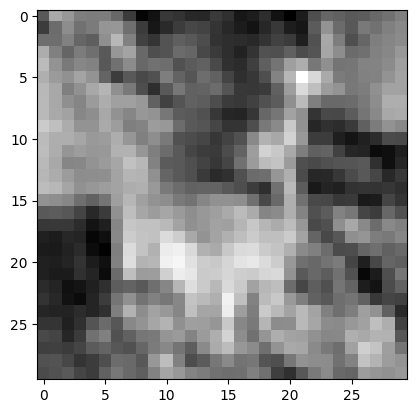

In [17]:
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [19]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
img_tensor = to_tensor(img)
output = conv(img_tensor.unsqueeze(0))
img_tensor.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [20]:
with torch.no_grad():
    conv.bias.zero_()
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

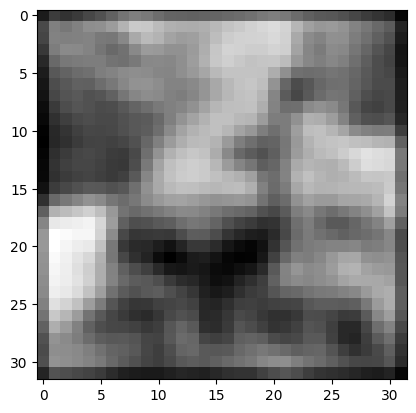

In [22]:
img_tensor = to_tensor(img)
output = conv(img_tensor.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [24]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                    [-1.0, 0.0, 1.0],
                                    [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

In [26]:
pool = nn.MaxPool2d(2)
img_tensor = to_tensor(img)
output = pool(img_tensor.unsqueeze(0))
img_tensor.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [27]:
model = nn.Sequential(
nn.Conv2d(3, 16, kernel_size=3, padding=1),
nn.Tanh(),
nn.MaxPool2d(2),
nn.Conv2d(16, 8, kernel_size=3, padding=1),
nn.Tanh(),
nn.MaxPool2d(2),
# ...
)

In [28]:
model = nn.Sequential(
nn.Conv2d(3, 16, kernel_size=3, padding=1),
nn.Tanh(),
nn.MaxPool2d(2),
nn.Conv2d(16, 8, kernel_size=3, padding=1),
nn.Tanh(),
nn.MaxPool2d(2),
# ...
nn.Linear(8 * 8 * 8, 32),
nn.Tanh(),
nn.Linear(32, 2))

In [29]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [31]:
img_tensor = to_tensor(img)
model(img_tensor.unsqueeze(0))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)

In [32]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [33]:
model = Net()
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [35]:
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [37]:
model = Net()
img_tensor = to_tensor(img)
model(img_tensor.unsqueeze(0))

tensor([[-0.1827,  0.1720]], grad_fn=<AddmmBackward0>)

In [38]:
import datetime
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
            datetime.datetime.now(), epoch,
            loss_train / len(train_loader)))

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

# Definir la arquitectura del modelo
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # Entrada con 3 canales (RGB), 16 filtros
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 salidas para 10 clases

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 32 * 8 * 8)  # Aplanar el tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Definir el bucle de entrenamiento
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        print(f'Epoch {epoch}, Training loss: {loss_train/len(train_loader)}')

# Transformaciones para el conjunto de datos
transform = transforms.Compose([
    transforms.ToTensor()
])

# Cargar el conjunto de datos CIFAR-10
cifar2 = CIFAR10(root='data', train=True, transform=transform, download=True)

# Crear el DataLoader
train_loader = DataLoader(cifar2, batch_size=64, shuffle=True)

# Inicializar el modelo, el optimizador y la función de pérdida
model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

# Ejecutar el bucle de entrenamiento
training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
)


Files already downloaded and verified
Epoch 1, Training loss: 2.2342444289370875
Epoch 2, Training loss: 1.9671153305741527
Epoch 3, Training loss: 1.8050441938592954
Epoch 4, Training loss: 1.6571836424300739
Epoch 5, Training loss: 1.5359868430115682
Epoch 6, Training loss: 1.4481024454011941
Epoch 7, Training loss: 1.3815502913864068
Epoch 8, Training loss: 1.324568565925369
Epoch 9, Training loss: 1.2751278681370912
Epoch 10, Training loss: 1.231306984982527
Epoch 11, Training loss: 1.1921045279411404
Epoch 12, Training loss: 1.152377549720847
Epoch 13, Training loss: 1.120443366220235
Epoch 14, Training loss: 1.0860549040005336
Epoch 15, Training loss: 1.0570426439232838
Epoch 16, Training loss: 1.0266056426650727
Epoch 17, Training loss: 0.999099355295796
Epoch 18, Training loss: 0.9716730805309227
Epoch 19, Training loss: 0.9467499282811304
Epoch 20, Training loss: 0.9229650077460062
Epoch 21, Training loss: 0.8982429008197297
Epoch 22, Training loss: 0.8738412805225538
Epoch 23

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

# Definir la arquitectura del modelo (supongo que ya tienes un modelo llamado Net)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 32 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Transformaciones para convertir las imágenes a tensores
transform = transforms.Compose([
    transforms.ToTensor()
])

# Cargar los conjuntos de datos con la transformación
cifar2 = CIFAR10(root='data', train=True, transform=transform, download=True)
cifar2_val = CIFAR10(root='data', train=False, transform=transform, download=True)

# Crear los DataLoaders
train_loader = DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = DataLoader(cifar2_val, batch_size=64, shuffle=False)

# Función para validar el modelo
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.2f}".format(name, correct / total))

# Inicializar el modelo
model = Net()

# Ejecutar la validación
validate(model, train_loader, val_loader)

Files already downloaded and verified
Files already downloaded and verified
Accuracy train: 0.10
Accuracy val: 0.10


In [46]:
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

In [47]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt'))

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10520\398628253.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(data_path + 'birds_v

<All keys matched successfully>

In [48]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cpu.


In [49]:
import datetime
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch,loss_train / len(train_loader)))

In [50]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
shuffle=True)
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
training_loop(
n_epochs = 100,
optimizer = optimizer,
model = model,
loss_fn = loss_fn,
train_loader = train_loader,
)

2024-10-15 15:53:00.239850 Epoch 1, Training loss 2.239286927615895


KeyboardInterrupt: 